# MIT 6.036 Spring 2021: Homework 3


**Setup**

**Make a copy of this colab in your own Drive folder before executing. You can do this by going the File > Save a copy in Drive.**

Download the code distribution for this homework that contains test cases and helper functions. Run the next code block to download and import the code for this lab.

In [1]:
!rm -rf code_and_data_for_hw3*
!rm -rf mnist
!wget --no-check-certificate --quiet https://go.odl.mit.edu/subject/6.036/_static/catsoop/homework/hw03/code_and_data_for_hw03.zip
!unzip code_and_data_for_hw03.zip
!mv code_and_data_for_hw03/* .

from code_for_hw03 import *
import numpy as np
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

Archive:  code_and_data_for_hw03.zip
   creating: code_and_data_for_hw03/
  inflating: __MACOSX/._code_and_data_for_hw03  
  inflating: code_and_data_for_hw03/code_for_hw03.py  
  inflating: __MACOSX/code_and_data_for_hw03/._code_for_hw03.py  
Importing code_for_hw03


## 3) Implementing gradient descent
In this section we will implement generic versions of gradient descent and apply these to the logistic regression objective.

<b>Note: </b> If you need a refresher on gradient descent,
you may want to reference
<a href="https://canvas.mit.edu/courses/11118/files/1660165?module_item_id=404498">this week's notes</a>.

### 3.1) Implementing Gradient Descent
We want to find the $x$ that minimizes the value of the *objective
function* $f(x)$, for an arbitrary scalar function $f$.  The function
$f$ will be implemented as a Python function of one argument, that
will be a numpy column vector.  For efficiency, we will work with
Python functions that return not just the value of $f$ at $f(x)$ but
also return the gradient vector at $x$, that is, $\nabla_x f(x)$.

We will now implement a generic gradient descent function, `gd`, that
has the following input arguments:

* `f`: a function whose input is an `x`, a column vector, and
  returns a scalar.
* `df`: a function whose input is an `x`, a column vector, and
  returns a column vector representing the gradient of `f` at `x`.
* `x0`: an initial value of $x$, `x0`, which is a column vector.
* `step_size_fn`: a function that is given the iteration index (an
  integer) and returns a step size.
* `num_steps`: the number of iterations to perform

Our function `gd` returns a tuple:

* x: the value at the final step
* fx: the value of f(x) at the final step

**Hint:** This is a short function!

The main function to implement is `gd`, defined below.

In [3]:
def gd(f, df, x0, step_size_fn, num_steps):
    x = x0
    for i in range(num_steps):
        x -= step_size_fn(i) * df(x)
    return x, f(x)

To evaluate results, we also use a simple `package_ans` function,
which checks the final `x` and `fx` values.

The test cases are provided below, but you should feel free (and are encouraged!) to write more of your own.

In [4]:
test_gd(gd)

Test 1:
Passed!
Test 2:
Passed!


### 3.2) Numerical Gradient
Getting the analytic gradient correct for complicated functions is
tricky.  A very handy method of verifying the analytic gradient or
even substituting for it is to estimate the gradient at a point by
means of *finite differences*.

Assume that we are given a function $f(x)$ that takes a column vector
as its argument and returns a scalar value.  In gradient descent, we
will want to estimate the gradient of $f$ at a particular $x_0.$

The $i^{th}$ component of $\nabla_x f(x_0)$ can be estimated as
$$\frac{f(x_0+\delta^{i}) - f(x_0-\delta^{i})}{2\delta}$$
where $\delta^{i}$ is a column vector whose $i^{th}$ coordinate is
$\delta$, a small constant such as 0.001, and whose other components
are zero.
Note that adding or subtracting $\delta^{i}$ is the same as
incrementing or decrementing the $i^{th}$ component of $x_0$ by
$\delta$, leaving the other components of $x_0$ unchanged.  Using
these results, we can estimate the $i^{th}$ component of the gradient.


**For example**, take $x^(0) = (1,2,3)^T$. The gradient $\nabla_x f(x)$ is a vector of the derivatives of $f(x)$ with respect to each component of $x$, or $\nabla_x f(x) = (\frac{df(x)}{dx_1},\frac{df(x)}{dx_2},\frac{df(x)}{dx_3})^T$.

We can approximate the first component of $\nabla_x f(x)$ as
$$\frac{f((1,2,3)^T+(0.01,0,0)^T) - f((1,2,3)^T-(0.01,0,0)^T)}{2\cdot 0.01}.$$

(We add the transpose so that these are column vectors.)
**This process should be done for each dimension independently,
and together the results of each computation are compiled to give the
estimated gradient, which is $d$ dimensional.**

Implement this as a function `make_num_grad_fn` that takes as arguments the
objective function `f` and a value of `delta`, and returns a new
**function** that takes an `x` (a column vector of parameters) and
returns a gradient column vector.

**Note:** Watch  out for aliasing. If you do temp_x = x where x is a vector (numpy array), then temp_x is just another name for the same vector as x and changing an entry in one will change an entry in the other. You should either use x.copy() or remember to change entries back after modification.

In [5]:
def make_num_grad_fn(f, delta=0.001):
    def df(x):
        d = np.zeros(x.shape)
        for i in range(x.shape[0]):
            smaller = x.copy()
            larger = x.copy()
            smaller[i] -= delta
            larger[i] += delta
            d[i] = (1 / (2 * delta)) * (f(larger) - f(smaller))
        return d
    return df

The test cases are shown below; these use the functions defined in the previous exercise.


In [6]:
test_num_grad(make_num_grad_fn)

Test 1
Passed
Test 2
Passed
Test 3
Passed
Test 4
Passed


A faster (one function evaluation per entry), though sometimes less
accurate, estimate is to use:
$$\frac{f(x_0+\delta^{i}) - f(x_0)}{\delta}$$
for the $i^{th}$ component of $\nabla_x f(x_0).$

3.3) Using the Numerical Gradient
Recall that our generic gradient descent function takes both a function
`f` that returns the value of our function at a given point, and `df`,
a function that returns a gradient at a given point.  Write a function
`minimize` that takes only a function `f` and uses this function and
numerical gradient descent to return the local minimum.  
You may use the default of `delta=0.001` for `make_num_grad_fn`.

**Hint:** Your definition of `minimize` should call `make_num_grad_fn` exactly
once to return a function. Then you may call this function many times in your updates for numerical gradient descent.
You should return the same outputs as `gd`.

In [7]:
def minimize(f, x0, step_size_fn, num_steps):
    """
    Parameters:
      See definitions in part 1
    Returns:
      same output as gd
    """
    df = make_num_grad_fn(f)
    return gd(f, df, x0, step_size_fn, num_steps)


The test cases are below.

In [8]:
test_minimize(minimize)

Test 1
Passed
Test 2
Passed


### 4) Stochastic gradient

We will now write some general python code to implement gradient descent.

sgd takes the following as input: (Recall that the stochastic part refers to using a randomly selected point and corresponding label from the given dataset to perform an update. Therefore, your objective function for a given step will need to take this into account.)

<pre>
  X: a standard data array (d by n)
  y: a standard labels row vector (1 by n)
  J: a cost function whose input is a data point (a column vector), a label (1 by 1) and a weight vector w (a column vector) (in that order), and which returns a scalar.
  dJ: a cost function gradient (corresponding to J) whose input is a data point (a column vector), a label (1 by 1) and a weight vector w (a column vector) (also in that order), and which returns a column vector.
  w0: an initial value of weight vector 
  step_size_fn: a function that is given the (zero-indexed) iteration index (an integer) and returns a step size.
  max_iter: the number of iterations to perform
</pre>

It returns a tuple:

<pre>
w: the value of the weight vector at the final step
fs: the list of values of J found during all the iterations
ws: the list of values of intermediate 
</pre>

**Helpful Note**: We recommend that in your implementation, you append the current value of w to **ws** *before* updating it. Similarly, use the current value to compute the corresponding value of the objective and append it to **fs**. Specifically, the first element of fs should be the value of J calculated with w0, and fs should have length max_iter; similarly, the first element of ws should be w0, and ws should have length max_iter. w is the final w updated max_iter iterations.

You might find the function np.random.randint(n) useful in your implementation.

Hint: This is a short function; our implementation is around 10 lines.

In [9]:
def sgd(X, y, J, dJ, w0, step_size_fn, max_iter):
    ws, fs, w = [], [], w0.copy()
    n = y.shape[1]
    np.random.seed(0)
    for i in range(max_iter):
        k = np.random.randint(n)
        xi = X[:,k:k+1]
        yi = y[0,k:k+1]
        ws.append(w.copy())
        fs.append(J(xi, yi, w))
        w -= step_size_fn(i) * dJ(xi, yi, w)
        if i == max_iter - 1:
            return w, fs, ws

In [10]:
# you must have the num_grad function implemented before you can test the sgd function in colab 
test_sgd(sgd, make_num_grad_fn)

running test 1
running test 2
all tests passed


### 5) Tying Everything Together

In the next subsections, we assume that $X$ is a $d \times n$ matrix, $Y$ is a $1 \times n$ matrix, and $\theta$ is a $d \times 1$ matrix. Rewriting the ridge objective as matrix operations, we find that: 

$$ J_{\text{ridge}}(\theta) = \frac{1}{n} (\theta^T X - Y) (\theta^T X - Y)^T + \lambda ||\theta||^2 $$

When implementing `objective_func` and `objective_func_grad`, you *do not* need to concatenate a row of ones to `X`. Assume that the `X` input has already been preprocessed as such. 

#### 5.1 Gradient Descent and Stochastic Gradient Descent for Linear Regression


Write a function for $J_{\text{ridge}}(\theta)$.

In [11]:
def objective_func(X, Y, lam):
    """
    inputs: 
      X: a (dxn) numpy array. 
      Y: a (1xn) numpy array 
      lambda: regularization parameter 
    outputs: 
      f : a function that takes in a (dx1) numpy array "theta" and returns *as a float* the value of the ridge 
      regression objective when theta="theta"
    """
    def f(theta): 
        e = theta.T@X - Y
        return float((1/X.shape[1]) * e@e.T + lam * theta.T@theta)
    return f 


In [12]:
test_obj_func(objective_func)

All tests passed!


Write a function for $\nabla J_{\text{ridge}}(\theta)$ with respect to $\theta$. 


In [13]:
def objective_func_grad(X, Y, lam):
    """
    inputs: 
      X: a (dxn) numpy array. 
      Y: a (1xn) numpy array 
      lambda: regularization parameter 
    outputs: 
      df : a function that takes in a (dx1) numpy array "theta" and returns the gradient of the ridge regression 
      objective when theta="theta" 
    """
    def df(theta): 
        return (2/X.shape[1]) * X@(theta.T@X-Y).T + 2 * lam * theta
    return df 

In [14]:
test_d_obj_func(objective_func_grad)

all tests passed!


#### 5.2 Finding the Best Parameters


Let's load the Boston Housing dataset. Our goal is to build a linear regression model (with regularization) to predict the TARGET_VAL (which is the median value of owner-occupied homes) using all other available features in the dataset.

For more information about the Boston housing dataset, please visit this [link](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html). 

Note that the data pre-processing routine below normalizes each feature. You will learn more about Feature transformations in Week 5.

In what follows, we use Cross-Validation to select the best hyperparamters for gradient descent on the ridge regression model. Using the best hyperparameters, we will then make predictions on a reserved test set. You will also compare the results when using the gradient descent based implementation vs the analytic (closed form) solution.

In [15]:
## DO NOT EDIT BELOW.
# Pre-Processing the data and returning the train and test sets.

# load the dataset and do some data exploration
X_raw, y_raw = load_boston(return_X_y=True)
raw_data = np.concatenate((X_raw, y_raw[:, None]), axis=1)
xvars = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
yvars = ["TARGET_VAL"]

data = pd.DataFrame(raw_data, columns=xvars+yvars)

# Get the train and test splits to be used later.
X_train, y_train, X_test, y_test = get_data_splits_with_transforms(data, xvars, yvars)

**CODE REQUIRED HERE** Before we start using the Boston Housing dataset, let's implement the `ridge_gd` function. Given an input `X_train`, `y_train`, `lam`, `theta` and `step_size_fn`, run gradient descent on `X_train` and `y_train` starting from `theta = (dx1) vector of zeros`. Return the value of $\theta$ after running 2000 iterations of gradient descent. 

```
inputs: 
  X_train: a dxn numpy array 
  y_train: a 1xn numpy array 
  lam: lambda 
  step_size_fn: a function that takes in i, the current training iteration, and returns the step size for iteration i 

outputs: 
  theta: value of theta after 2000 iterations of gradient descent 
```
**Hint**: `objective_func` and `objective_func_grad` are very useful here! \
**Hint**: You can also use your `gd` function \
**Hint**: Previously, you've minimized f as a function of x. Now, X and y are constant. What variable are you minimizing over now? \

In [22]:
def ridge_gd(X_train, y_train, lam, step_size_fn): 
  # TODO 
  # hint: number of iterations = 2000 
  # hint: start from theta = (dx1) vector of zeros
  theta = np.zeros((X_train.shape[0], 1))
  f, df = objective_func(X_train, y_train, lam), objective_func_grad(X_train, y_train, lam)
  return gd(f, df, theta, step_size_fn, 2000)[0]

In [23]:
test_ridge_gd(ridge_gd)

all tests pass!


**CODE REQUIRED HERE** In `cross_validate_gd`, run 5-fold cross-validation on the X and y dataset. Use gradient descent to train a linear model for the `X`, `y` data. We've provided a for loop that iterates over each split. In this code: 

```
  X_train_split, y_train_split: data to use for training. This is a (d x n) numpy array, where n=the number of datapoints in k-1 folds 
  X_val_split, y_val_split: data to use for evaluating the model. This is a (d x n) numpy array, where n=the number of datapoints in 1 fold
```

**Hint**: Use `ridge_gd` here. \
**Hint**: Take a look at the solutions for last week's cross_validate code if you get stuck

In [24]:
def cross_validate_gd(X, y, lam, step_size_fn):
  """
  Returns k-fold cross-validation loss. On each of the k folds, 
    train a linear regression model using gradient descent. Return 
    the average loss across the k folds. 
  """
  total_loss = 0
  kf = KFold(n_splits=5)
  for train_index, test_index in kf.split(X, y=y):
    X_train_split, y_train_split = X[train_index].T, y[train_index].T
    # TODO - train model on X_train_split, y_train_split using gradient descent
    # hint - use variables step_size_fn and lam
    th = ridge_gd(X_train_split, y_train_split, lam, step_size_fn)
    X_val_split, y_val_split = X[test_index].T, y[test_index].T
    # TODO - evaluate model on X_val_split, y_val_split, add loss to total_loss
    total_loss += objective_func(X_val_split, y_val_split, 0)(th)
  return total_loss / kf.n_splits

Now it's time to run grid search! We are interested in running grid search over $\lambda \in \{{1e-4, 1e-3, \cdots, 1e-1\}}$ and $\eta \in \{{1e-6, 1e-5, \cdots, 1e-2\}}$. 

These two cells are ready to run if you've correctly implemented `cross_validate_gd`. Use the outputs of these cells to answer the rest of problem 5.2. 

We've also already implemented `cross_validate_analytic` for you. This function returns the cross-validation loss for linear regression models trained with the analytic solution for the squared loss equation. 

**Note: The next two cells print the cross-validation loss, not the testing set loss! Run the last cell in this notebook for the testing set loss.**


In [25]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
lams = [1e-1, 1e-2, 1e-3, 1e-4]

# This code runs grid search over the training parameters in `learning_rates` and `lams`
for rate in learning_rates:
  for lam in lams:
    learning_rate_fn = lambda i : rate # learning rate = `rate` throughout training
    cross_validation_loss = cross_validate_gd(X_train, y_train, lam, learning_rate_fn)
    print(f"Loss on dataset with lambda={lam}, rate={rate} : cross_validation_loss {cross_validation_loss:.6f}")

Loss on dataset with lambda=0.1, rate=0.01 : cross_validation_loss 0.423505
Loss on dataset with lambda=0.01, rate=0.01 : cross_validation_loss 0.488424
Loss on dataset with lambda=0.001, rate=0.01 : cross_validation_loss 0.504579
Loss on dataset with lambda=0.0001, rate=0.01 : cross_validation_loss 0.506418
Loss on dataset with lambda=0.1, rate=0.001 : cross_validation_loss 0.398521
Loss on dataset with lambda=0.01, rate=0.001 : cross_validation_loss 0.404061
Loss on dataset with lambda=0.001, rate=0.001 : cross_validation_loss 0.404962
Loss on dataset with lambda=0.0001, rate=0.001 : cross_validation_loss 0.405056
Loss on dataset with lambda=0.1, rate=0.0001 : cross_validation_loss 0.522173
Loss on dataset with lambda=0.01, rate=0.0001 : cross_validation_loss 0.518517
Loss on dataset with lambda=0.001, rate=0.0001 : cross_validation_loss 0.518152
Loss on dataset with lambda=0.0001, rate=0.0001 : cross_validation_loss 0.518116
Loss on dataset with lambda=0.1, rate=1e-05 : cross_valida

In [26]:
lams = [1e-1, 1e-2, 1e-3, 1e-4]

# This code runs grid search over the training parameters in `lams`
for lam in lams:
  cross_validation_loss = cross_validate_analytic(X_train, y_train, lam).item()
  print(f"Loss on dataset with lambda={lam}: cross_validation_loss {cross_validation_loss:.6f}")

Loss on dataset with lambda=0.1: cross_validation_loss 0.551118
Loss on dataset with lambda=0.01: cross_validation_loss 0.553890
Loss on dataset with lambda=0.001: cross_validation_loss 0.554177
Loss on dataset with lambda=0.0001: cross_validation_loss 0.554205


We will now use the best params found above to build a model on the entire training set (X_train, y_train), get the $\theta$ values and use them to make predictions for the test set (X_test) and evaluate the error using the *actual* values (y_test). We will compare this error for the gradient descent based implementation vs the analytic solution.


**CODE REQUIRED HERE**:

1. Update **best_lam_gd** and **best_rate_gd** using the best $\lambda$ and $\eta$ values you found using **cross_validate_gd**() above.

2. Update **best_lam_analytic** using the best $\lambda$ value found by using **cross_validate_analytic**() above.



Test loss for GD based implementation=0.824
Test loss for Analytic (closed form) implementation=0.892


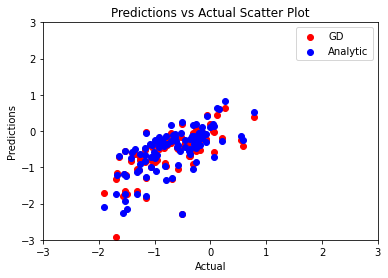

In [27]:
#### Using the functions above along with the best performing hyperparams to
### determine the test set errors. Please specify the best lambda and learning 
### rates for the GD and Analytic cases that you found above.

# GD
best_lam_gd = 0.1      ### to be specified
best_rate_gd = 0.001  ### to be specified

# get_gd_predictions() function is defined in the hw03 code you imported at 
# the very top. Check the code out if you are curious about the implementation.
gd_predictions, gd_error = get_gd_predictions_and_error(
    objective_func, objective_func_grad, gd, X_train, y_train, X_test, y_test, best_lam_gd, best_rate_gd)

# Analytic
best_lam_analytic = 0.1 ### to be specified

# get_analytic_predictions_and_error() function is defined in the hw03 code 
# you imported at the very top. Check the code out if you are curious about the 
# implementation.
analytic_predictions, analytic_error = get_analytic_predictions_and_error(
    X_train, y_train, X_test, y_test, best_lam_analytic)


print(f"Test loss for GD based implementation={gd_error:0.3f}")
print(f"Test loss for Analytic (closed form) implementation={analytic_error:0.3f}")


#### (Optional) Compare the results by viewing the scatter plots for predictions.
plt.scatter(y_test, gd_predictions, color='red', label='GD')
plt.scatter(y_test, analytic_predictions, color='blue', label='Analytic')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Scatter Plot')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc="upper right")
plt.show()